<div dir=rtl>
    <h2>
        سوال اول پروژه - سینا باقری نژاد
    </h2>
    </div>

<div dir=rtl>
    ابتدا کتابخوانه های مورد نظر را فراخوانی می کنیم.
    </div>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

<div dir=rtl>
    به منظور نمایش خروجیها در آینده، تابعی را تعریف می کنیم
    </div>

In [2]:
def showImages(img1, img2):
    plt.figure(figsize=(18, 10))
    plt.subplot(1,2,1); plt.imshow(img1)
    plt.subplot(1,2,2); plt.imshow(img2)
    plt.show()

<div dir=rtl>
    دو تصویر ساختمان را فراخوانده و نمایش میدهیم. همانطور که مشخص است، دو تصویر از یک ساختمان گرفته شده و موقعیت دوربین در هر دو تصویر یکسان است اما زاویه تصویر برداری متفاوت است. در تصویر دوم (تصویر سمت راست) دوربین به سمت راست حرکت کرده است. در این تمرین میخواهیم ماتریس هموگرافی را طوری بیابیم که از تصویر اول (سمت چپ) بتوان به تصویر دوم (سمت راست) منطبق شد.
    </div>

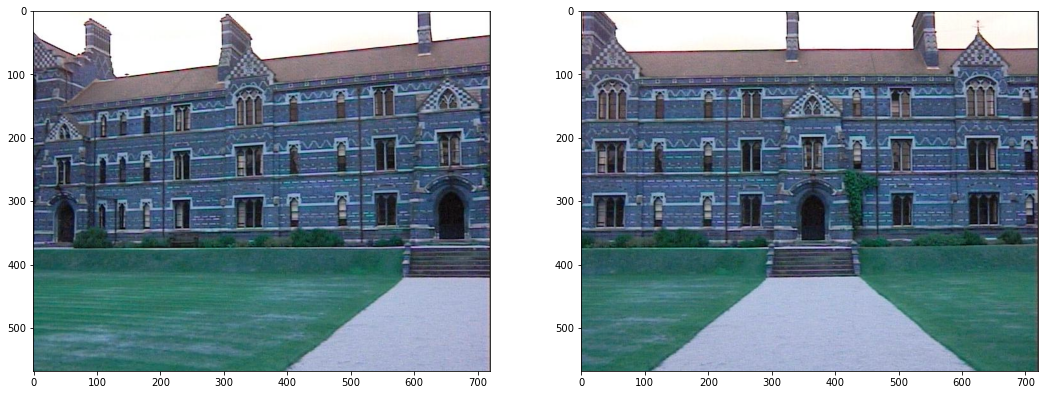

In [3]:
image1 = cv2.imread('images/building1.jpg')
image2 = cv2.imread('images/building2.jpg')
showImages(image1, image2)

<div dir=rtl>
    ابتدا نقاط کلیدی در هر دو تصویر را شناسایی می کنیم. به این منظور از روش Harris استفاده کرده ایم. در این روش کنجها و گوشه ها به عنوان نقاط ویژگی در نظر گرفته می شوند. این نقاط را بر روی تصاویر نمایش داده ایم. همانطور که مشخص است، با تغییر پارامترها توانسته ایم نقاط مشخص و خوبی را تعیین کنیم.
    </div>

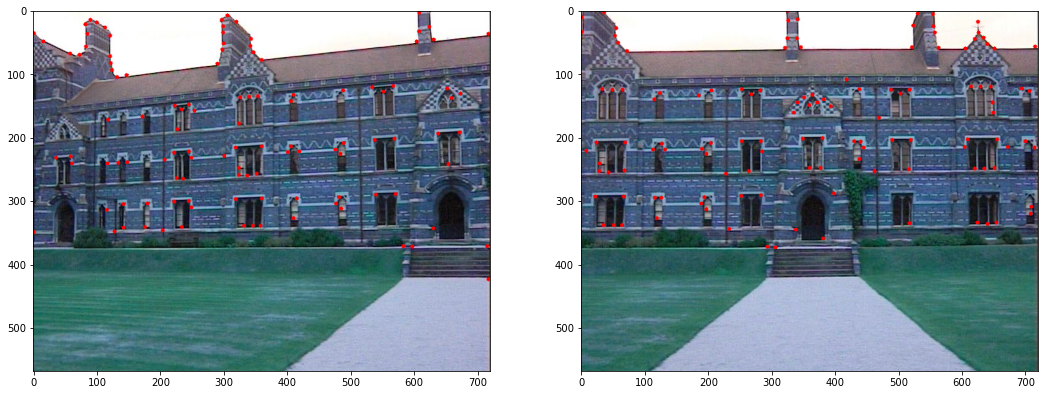

In [4]:
def harrisCorner(img):
    feature_params = dict( maxCorners = 0,
                       qualityLevel = 0.05,
                       minDistance = 10,
                       useHarrisDetector=True,
                       blockSize = 7,
                       k = 0
                     )
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, mask = None, **feature_params)
    return corners

def showCorners(image, corners):
    img = image.copy()
    corners = np.int0(corners)
    for i in corners:
        x,y = i.ravel()
        cv2.circle(img,(x,y),3,255,-1)
    return img


corners1 = harrisCorner(image1)
corners2 = harrisCorner(image2)

showImages(showCorners(image1, corners1), showCorners(image2, corners2))

<div dir=rtl>
    به منظور اینکه حرکت نقاط ویژگی را بین این دو تصویر رصد کنیم، از روش Lucas-Kanade استفاده خواهیم کرد. این روش نقاط ویژگی در یک تصویر را گرفته و محل آنها در تصویر دوم را پیش بینی میکند. از آنجایی که ما در هر دو تصویر نقاط ویژگی داریم، از این الگوریتم هر دو تصویر استفاده کرده ایم. یعنی هم بررسی کرده ایم که نقاط ویژگی تصویر اول به چه نقاطی در تصویر دوم رفته اند، و هم بررسی کرده ایم که نقاط ویژگی در تصویر دوم، از چه نقاطی از تصویر اول آمده اند. سپس نقاط متناظر را با هم گزارش میکنیم. اینطور از تمام نقاط ویژگی دو تصویر استفاده شده است.
    </div>

In [5]:
def lk_tracker(img1, img2, keypoints):
    lk_params = dict(winSize  = (5,5),
                     maxLevel = 7,
                     criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
                    )
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    p0 = keypoints
    mask = np.zeros_like(img1)
    color = np.random.randint(0,255,(100,3))
    p1, st, err = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)
    if p1 is not None:
        good_points_1 = p0[st==1]
        good_points_2 = p1[st==1]
    return good_points_1, good_points_2

def two_side_lk(img1, img2, keypoints1, keypoints2):
    p1, p2 = lk_tracker(img1, img2, keypoints1)
    q2, q1 = lk_tracker(img2, img1, keypoints2)
    good_points_1 = np.concatenate((p1, q1), axis=0)
    good_points_2 = np.concatenate((p2, q2), axis=0)
    return good_points_1, good_points_2

good_points_1, good_points_2 = two_side_lk(image1, image2, corners1, corners2)

<div dir=rtl>
    همانطور که میبینید در دو تصویر بردارهایی مشاهده می شود. ابتدای هر بردار نقطه ای را نمایش می دهد که در تصویر اول بوده است و انتهای بردار نشان میدهد که آن نقطه به چه محلی در تصویر دوم رفته است. همانطور که میبینید، تعداد بردارهای حاصل بسیار زیاد هستند و همه با هم در جهت چرخش تصویر موافق نیستند. بنابراین لازم است با رای گیری به روش ransac آن جهت بردارهایی که رای بیشتری را میآورند را بدست آوریم.
    </div>

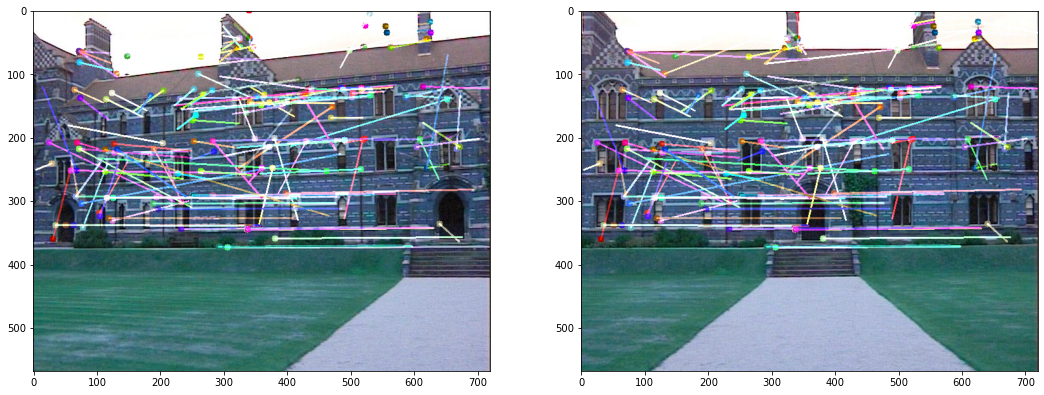

In [6]:
color = np.random.randint(0, 255, (len(good_points_1), 3))
mask = np.zeros_like(image1)
frame1 = image1.copy()
frame2 = image2.copy()
for i,(i2,i1) in enumerate(zip(good_points_2, good_points_1)):
    a,b = i2.ravel()
    c,d = i1.ravel()
    mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
    frame1 = cv2.circle(frame1,(int(a),int(b)),5,color[i].tolist(),-1)
    frame2 = cv2.circle(frame2,(int(a),int(b)),5,color[i].tolist(),-1)
img1 = cv2.add(frame1,mask)
img2 = cv2.add(frame2,mask)

showImages(img1, img2)

<div dir=rtl>
    به منظور محاسبه ماتریس هموگرافی ما نیاز به ۴ جفت نقطه متناظر یا همان بردارهای تصویر قبل داریم. با هر ۴ جهت نقطه، چه با هم موافق یا مخالف باشند، یک ماتریس هموگرافی حاصل می شود. تابع مربوط به محاسبه ماتریس هموگرافی در ادامه تعریف شده است. همچنین تابعی برای انتخاب تصادفی بین این بردارها نیز تعریف شده است. با هر بار اجرای تکه کد پایین، یک ماتریس هموگرافی تولید می شود که به احتمال زیاد با تکرار این کار ماتریس متفاوتی حاصل خواهد شد. زیرا هر بار ۴ تا از بردارهای تصویر بالا را به تصادف انتخاب کرده و با توجه به آن ماتریس هموگرافی را محاسبه می کند. 
    </div>

In [7]:
def get_random_points(points_1, points_2, k=4):
    indices = random.sample(list(range(len(points_1))), k)
    return points_1[indices], points_2[indices]

def homography(p1, p2):
    A = np.zeros((len(p1) * 2, 9))
    for i in range(len(p1)):
        x1, y1 = p1[i, 0], p1[i, 1]
        x2, y2 = p2[i, 0], p2[i, 1]
        A[2*i] = [-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2]
        A[2*i+1] = [0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2]
        
    u, s, vh = np.linalg.svd(A)
    h = vh[8].reshape(3, 3)
    return h

p1, p2 = get_random_points(good_points_1, good_points_2)
h = homography(p1, p2)
h

array([[-1.84828805e-04, -2.04958167e-03,  5.15536383e-01],
       [-3.01941519e-04, -3.40949362e-03,  8.56849445e-01],
       [-1.37988185e-06, -1.55709301e-05,  3.91355677e-03]])

<div dir=rtl>
    بنابراین برای اینکه ماتریس هموگرافی متناظر با جهت حرکت دوربین را پیدا کنیم، از رای گیری به روش Ransac استفاده خواهیم کرد. در این روش هر بار به طور تصادف ۴ جفت نقطه متناظر در نظر گرفته شده و ماتریس هموگرافی را تشکیل میدهیم. سپس همه نقاط را با استفاده از این ماتریس هموگرافی انتقال میدهیم. اگر اختلاف نقطه انتقال یافته با نقطه ای که بردار مربوطه هر نقطه بیان میکند کم بود، آن نقطه به عنوان یک رای برای ماتریس هموگرافی تعیین میشود. بدیهی است که برای محاسبه ماتریس هموگرافی بهینه، باید همه حالات ممکن بررسی شود. اما چون با توجه به تعداد بالای جفت نقاط، تعداد حالات بسیار بالا است، تعداد دور نمونه گیری را با استفاده از علم آمار طوری تعیین میکنیم که احتمال اینکه بتوانیم یک ترکیب از ۴ برداری که جهت درست را مشخص میکنند انتخاب کنیم حداقل به اندازه p باشد. یعنی بتوانیم با ضریب اطمینان p بگوییم که هیچ بردار نادرست و پرتی در تعیین هموگرافی نقشی نداشته است. 
    </div>

In [8]:
def to_homogeneous(points):
    return np.append(points, np.ones([points.shape[0], 1]), axis=1)

def to_cartesian(points):
    return np.delete(points / points[:,-1].reshape(-1,1), -1, axis=1)

def n_iteration(p, e, s=4):
    return round(np.log(1-p)/np.log(1-(1-e)**s))

def get_votes(good_points_1, good_points_2, h, threshold):
    points_prime = to_cartesian((h @ to_homogeneous(good_points_1).T).T)
    votes = np.linalg.norm(points_prime - good_points_2, axis=1) < threshold
    count_votes = votes.sum()
    voters = (good_points_1[votes], good_points_2[votes])
    return count_votes, voters

def ransac(good_points_1, good_points_2, iterations, threshold=5):
    best_h = np.zeros((3, 3))
    best_votes = 0
    best_voters = (0, 0)
    for _ in range(iterations):
        p1, p2 = get_random_points(good_points_1, good_points_2)
        h = homography(p1, p2)
        votes, voters = get_votes(good_points_1, good_points_2, h, threshold)
        if votes > best_votes:
            best_votes = votes
            best_h = h
            best_voters = voters
    return best_h, best_votes, best_voters

<div dir=rtl>
    در تصویر زیر، بردارها (جفت نقاط) که به ماتریس هموگرافی منتخب از طریق ransac رای داده اند را مشاهده می کنید. ماتریس هموگرافی ۳۲ رای موافق از جفت نقاط را کسب کرده است. همانطور که دیده میشود همه این بردارها به حرکت دوربین به سمت راست اعتقاد دارند و به نظر میرسد ماتریس هموگرافی مناسبی انتخاب شده است.
    </div>

Max Votes: 32


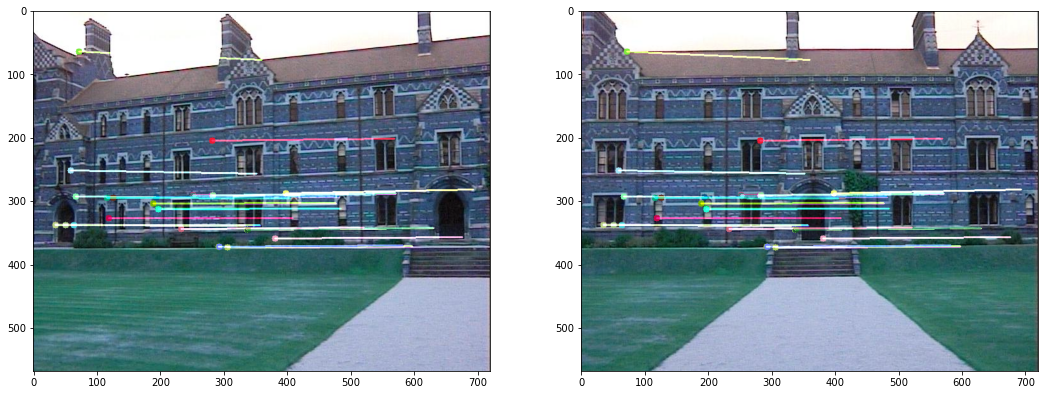

In [9]:
p = 0.99
e = 0.9
iterations = n_iteration(p, e)

h, v, bv = ransac(good_points_1, good_points_2, iterations, threshold=5)

color = np.random.randint(0, 255, (len(bv[1]), 3))
mask = np.zeros_like(image1)
frame1 = image1.copy()
frame2 = image2.copy()
for i,(i2,i1) in enumerate(zip(bv[1], bv[0])):
    a,b = i2.ravel()
    c,d = i1.ravel()
    mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
    frame1 = cv2.circle(frame1,(int(a),int(b)),5,color[i].tolist(),-1)
    frame2 = cv2.circle(frame2,(int(a),int(b)),5,color[i].tolist(),-1)
img1 = cv2.add(frame1,mask)
img2 = cv2.add(frame2,mask)

print('Max Votes:', v)
showImages(img1, img2)

<div dir=rtl>
    حال با استفاده از ماتریس هموگرافی محاسبه شده، تصویر اول را به طوری دوران میدهیم که بر تصویر دوم منطبق شود. در زیر دو تصویر را مشاهده میکنید. تصویر سمت راست همان تصویر دوم است و تصویر سمت چپ، تصویر اول است که با چرخش در محل تصویر دوم آمده است. همانطور که مشخص است این حرکت به خوبی انجام شده و تصویر اول دقیقا در محل تصویر دوم قرار گرفته است.
    </div>

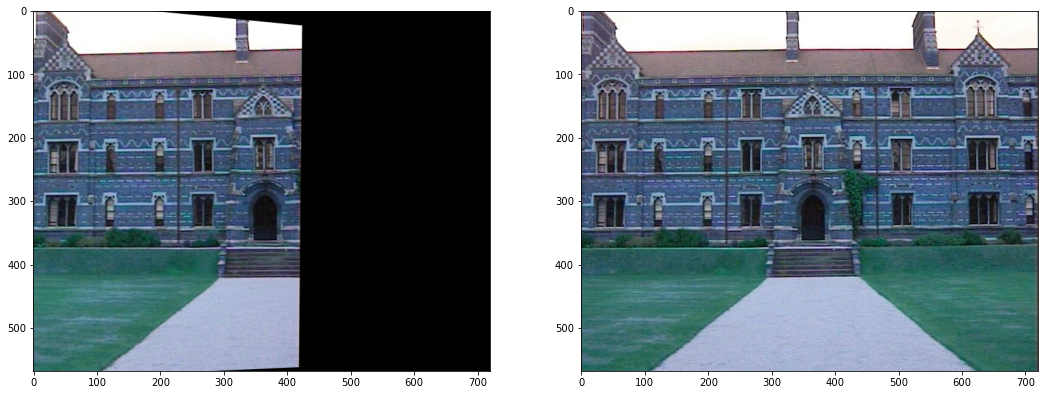

In [10]:
x, y = image2.shape[:2]
transfered_image1 = cv2.warpPerspective(image1, h, (y, x))
showImages(transfered_image1, image2)